# Day 13 Random-Forests
随机森林是一个包含多个决策树的分类器，并且其输出的类别是由个别树输出的类别的众数而定

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


warnings.filterwarnings(action='ignore')

二叉树分支方法可以非常有效地进行分类:在一棵结构合理的决策树中，每个问题基本上都可将种类可能性减半;即使是对大量种类进行决策时，也可以很快地缩小选择不过，决策树的难点在于如何设计每一步的问题。
## 1.创建一棵决策树

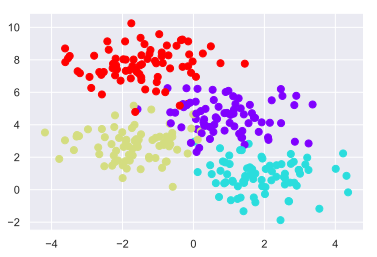

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

在这组数据上构建的简单决策树不断将数据的一个特征或另一个特征按照某种判定条件进 行分割。每分割一次，都将新区域内点的多数投票结果标签分配到该区域上。下图展示 了决策树对这组数据前四次分割的可视化结果。

![图](../figure/random_forests.png)

需要注意的是，在第一次分割之后，上半个分支里的所有数据点都没有变化，因此这个分 支不需要继续分割。**除非一个节点只包含一种颜色，那么每次分割都需要按照两种特征中 的一种对每个区域进行分割。**

在 Scikit-Learn 中使用决策树拟合数据，可以用 DecisionTreeClassifier 评估器

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)
tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # 画出训练数据
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
#     ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 用评估器拟合数据
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # np.c_: 按column列连接两个矩阵，就是把两矩阵左右相连,类似pd.merge
    # np.r_: 按row行连接两个矩阵，就是把两矩阵上下相加, 类似pd.concat
    
    # 为结果生成彩色图
    n_classes = len(np.unique(y)) # ??
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

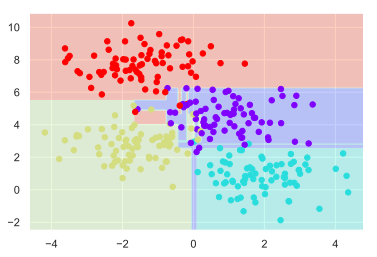

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

请注意，随着决策树深度的不断增加，我们可能会看到形状非常奇怪的分类区域--过拟合,如下图:

In [6]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

## 2. 决策树与过拟合
这种过拟合其实正是决策树的一般属性——决策树非常容易陷得很深，因此往往会拟合局部数据

In [7]:
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

## 3.评估器集成算法:随机森林
通过组合多个过拟合评估器来降低过拟合程度的想法其实是一种集成学习方法，称为装袋算法.装袋算法使用并行评估器对数据进行有放回抽取集成(也可以说是大杂烩)，每个 评估器都对数据过拟合，通过求均值可以获得更好的分类结果。随机决策树的集成算法就 是随机森林。
<br>可以用 Scikit-Learn 的 **BaggingClassifier** 元评估器来实现这种装袋分类器

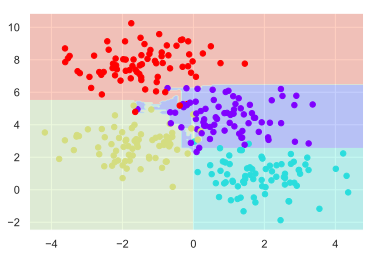

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

在这个示例中，我们让每个评估器拟合样本 80% 的随机数。
<br>在 Scikit-Learn 里**对随机决策树集成算法的优化是通过 RandomForestClassifier 评估器**实
现的，它会自动进行随机化决策。

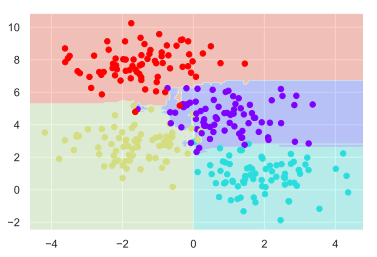

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## 随机森林回归
前面介绍了随机森林分类的内容。其实随机森林也可以用作回归(处理连续变量，而不是 离散变量)。随机森林回归的评估器是 RandomForestRegressor
<hr>下面的数据通过快慢振荡组合而成

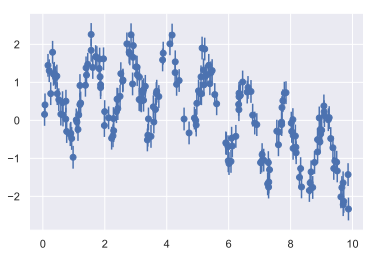

In [10]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise


y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

通过随机森林回归器，可以获得下面的最佳拟合曲线:

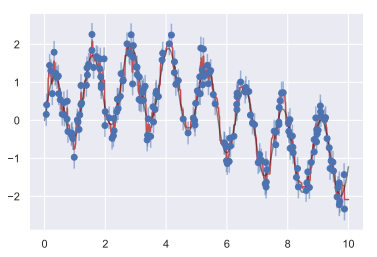

In [11]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

真实模型是平滑曲线，而随机森林模型是锯齿线。从图中可以看出，无参数的随机森林模
型非常适合处理多周期数据，不需要我们配置多周期模型!